In [13]:
import tensorflow as tf
import os
import random

AUTO = tf.data.experimental.AUTOTUNE

In [3]:
try:
  tpu_address = 'grpc://' + os.environ['COLAB_TPU_ADDR'] # contains address
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu_address) #connect to cluster nad initialise TPU
  tf.config.experimental_connect_to_cluster(tpu) # connect to cluster containing the TPU
  tf.tpu.experimental.initialize_tpu_system(tpu) # initialise tpu system on it
  strategy = tf.distribute.experimental.TPUStrategy(tpu) # tpu strategy
  print('Running on TPU' , tpu.cluster_spec().as_dict()['worker'] )
  print('Number of accelerators :' , strategy.num_replicas_in_sync)

except ValueError:
  print('TPU failed to initialise')

INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Initializing the TPU system: grpc://10.87.101.2:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.87.101.2:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Running on TPU ['10.87.101.2:8470']
Number of accelerators : 8


In [6]:
SIZE = 224 #["192","224","331","512"]
IMAGE_SIZE = [SIZE,SIZE]

In [8]:
GCS_PATTERN = f'gs://flowers-public/tfrecords-jpeg-{SIZE}x{SIZE}/*.tfrec'

BATCH_SIZE = 128 #per core batch

VALIDATION_SPLIT = 0.2

CLASSES = ['daisy', 'dandelion','roses','sunflowers','tulips']

#splitting data files b/w train and val

filenames = tf.io.gfile.glob(GCS_PATTERN)
random.shuffle(filenames)


split = int(len(filenames) * VALIDATION_SPLIT)
training_filenames = filenames[split:]
validation_filenames = filenames[:split]
print(print(f"Pattern matches {len(filenames)} data files. Splitting dataset into {len(training_filenames)} training files and {len(validation_filenames)} validation files"))

validation_steps = int(3670 // len(filenames) * len(validation_filenames)) // BATCH_SIZE
steps_per_epoch = int(3670 // len(filenames) * len(training_filenames)) // BATCH_SIZE
print(f"With a batch size of {BATCH_SIZE}, there will be {steps_per_epoch} batches per training epoch and {validation_steps} batch(es) per validation run.")

Pattern matches 16 data files. Splitting dataset into 13 training files and 3 validation files
None
With a batch size of 128, there will be 23 batches per training epoch and 5 batch(es) per validation run.


In [9]:
def read_tfrecord(example):
  features = {
              "image" : tf.io.FixedLenFeature([], tf.string), # tf.string -> bytestring
              "class" : tf.io.FixedLenFeature([], tf.int64 ), #shape [] means scalar
              "one_hot_class" : tf.io.VarLenFeature(tf.float32),
  }

  example = tf.io.parse_single_example(example, features)
  image = example['image']
  class_label = example['class']
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, [224,224])
  image = tf.cast(image, tf.float32) #image to [0,1] range
  class_label = tf.cast(class_label, tf.int32)
  return image, class_label


def load_dataset(filenames):
  # read from TFRecords. For optimal performance, use "interleave(tf.data.TFRecordDataset, ...)"
  # to read from multiple TFRecord files at once and set the option experimental_deterministic = False
  # to allow order-altering optimizations.

  option_no_order = tf.data.Options()
  option_no_order.experimental_deterministic = False

  dataset = tf.data.Dataset.from_tensor_slices(filenames)
  dataset = dataset.with_options(option_no_order)
  dataset = dataset.interleave(tf.data.TFRecordDataset, cycle_length=16, num_parallel_calls=AUTO) # faster
  dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)
  return dataset

def get_batched_dataset(filenames):
  dataset = load_dataset(filenames)
  dataset = dataset.shuffle(2048)
  dataset = dataset.batch(BATCH_SIZE, drop_remainder=False) # drop_remainder will be needed on TPU
  dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
  return dataset

def get_training_dataset():
  dataset = get_batched_dataset(training_filenames)
  dataset = strategy.experimental_distribute_dataset(dataset)
  return dataset

def get_validation_dataset():
  dataset = get_batched_dataset(validation_filenames)
  dataset = strategy.experimental_distribute_dataset(dataset)
  return dataset

In [10]:
class MyModel(tf.keras.Model):
  def __init__(self, classes):
    super(MyModel, self).__init__()
    self._conv1a = tf.keras.layers.Conv2D(kernel_size=3, filters=16, padding='same', activation='relu')
    self._conv1b = tf.keras.layers.Conv2D(kernel_size=3, filters=30, padding='same', activation='relu')
    self._maxpool1 = tf.keras.layers.MaxPooling2D(pool_size=2)
    
    self._conv2a = tf.keras.layers.Conv2D(kernel_size=3, filters=60, padding='same', activation='relu')
    self._maxpool2 = tf.keras.layers.MaxPooling2D(pool_size=2)
    self._drop1 = tf.keras.layers.Dropout(0.2)
    
    self._conv3a = tf.keras.layers.Conv2D(kernel_size=3, filters=90, padding='same', activation='relu')
    self._maxpool3 = tf.keras.layers.MaxPooling2D(pool_size=2)
    self._drop2 = tf.keras.layers.Dropout(0.2)
    
    self._conv4a = tf.keras.layers.Conv2D(kernel_size=3, filters=110, padding='same', activation='relu')
    self._maxpool4 = tf.keras.layers.MaxPooling2D(pool_size=2)
    
    self._conv5a = tf.keras.layers.Conv2D(kernel_size=3, filters=130, padding='same', activation='relu')
    self._conv5b = tf.keras.layers.Conv2D(kernel_size=3, filters=40, padding='same', activation='relu')
    
    self._pooling = tf.keras.layers.GlobalAveragePooling2D()
    self._classifier = tf.keras.layers.Dense(classes, activation='softmax')

  def call(self, inputs):
    x = self._conv1a(inputs)
    x = self._conv1b(x)
    x = self._maxpool1(x)

    x = self._conv2a(x)
    x = self._maxpool2(x)
    x = self._drop1(x)

    x = self._conv3a(x)
    x = self._maxpool3(x)
    x = self._drop2(x)

    x = self._conv4a(x)
    x = self._maxpool4(x)

    x = self._conv5a(x)
    x = self._conv5b(x)

    x = self._pooling(x)
    x = self._classifier(x)
    return x

In [11]:
with strategy.scope():
  model = MyModel(classes=len(CLASSES))
  # Set reduction to `none` so we can do the reduction afterwards and divide by
  # global batch size.
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
      reduction=tf.keras.losses.Reduction.NONE)

  def compute_loss(labels, predictions):
    per_example_loss = loss_object(labels, predictions)
    return tf.nn.compute_average_loss(per_example_loss, global_batch_size=BATCH_SIZE * strategy.num_replicas_in_sync)

  test_loss = tf.keras.metrics.Mean(name='test_loss')

  train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
      name='train_accuracy')
  test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
      name='test_accuracy')
  
  optimizer = tf.keras.optimizers.Adam()

  @tf.function
  def distributed_train_step(dataset_inputs):
    per_replica_losses = strategy.run(train_step,args=(dataset_inputs,))
    print(per_replica_losses)
    return strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_losses,
                           axis=None)
 
  @tf.function
  def distributed_test_step(dataset_inputs):
    strategy.run(test_step, args=(dataset_inputs,))


  def train_step(inputs):
    images, labels = inputs

    with tf.GradientTape() as tape:
      predictions = model(images)
      loss = compute_loss(labels, predictions)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_accuracy.update_state(labels, predictions)

    return loss 

  def test_step(inputs):
    images, labels = inputs

    predictions = model(images)
    loss = loss_object(labels, predictions)

    test_loss.update_state(loss)
    test_accuracy.update_state(labels, predictions)



In [14]:
EPOCHS = 40
with strategy.scope():
  for epoch in range(EPOCHS):
    # TRAINING LOOP
    total_loss = 0.0
    num_batches = 0
    for x in get_training_dataset():
      total_loss += distributed_train_step(x)
      num_batches += 1
    train_loss = total_loss / num_batches

    # TESTING LOOP
    for x in get_validation_dataset():
      distributed_test_step(x)

    template = ("Epoch {}, Loss: {:.2f}, Accuracy: {:.2f}, Test Loss: {:.2f}, "
                "Test Accuracy: {:.2f}")
    print (template.format(epoch+1, train_loss,
                           train_accuracy.result()*100, test_loss.result() / strategy.num_replicas_in_sync,
                           test_accuracy.result()*100))

    test_loss.reset_states()
    train_accuracy.reset_states()
    test_accuracy.reset_states()

PerReplica:{
  0: Tensor("output_0_shard_0:0", shape=(), dtype=float32),
  1: Tensor("output_0_shard_1:0", shape=(), dtype=float32),
  2: Tensor("output_0_shard_2:0", shape=(), dtype=float32),
  3: Tensor("output_0_shard_3:0", shape=(), dtype=float32),
  4: Tensor("output_0_shard_4:0", shape=(), dtype=float32),
  5: Tensor("output_0_shard_5:0", shape=(), dtype=float32),
  6: Tensor("output_0_shard_6:0", shape=(), dtype=float32),
  7: Tensor("output_0_shard_7:0", shape=(), dtype=float32)
}
PerReplica:{
  0: Tensor("output_0_shard_0:0", shape=(), dtype=float32),
  1: Tensor("output_0_shard_1:0", shape=(), dtype=float32),
  2: Tensor("output_0_shard_2:0", shape=(), dtype=float32),
  3: Tensor("output_0_shard_3:0", shape=(), dtype=float32),
  4: Tensor("output_0_shard_4:0", shape=(), dtype=float32),
  5: Tensor("output_0_shard_5:0", shape=(), dtype=float32),
  6: Tensor("output_0_shard_6:0", shape=(), dtype=float32),
  7: Tensor("output_0_shard_7:0", shape=(), dtype=float32)
}
PerReplica:{

In [15]:
import matplotlib.pyplot as plt

def dataset_to_numpy_util(dataset, N):
  dataset = dataset.batch(N)
  
  if tf.executing_eagerly():
    # In eager mode, iterate in the Datset directly.
    for images, labels in dataset:
      numpy_images = images.numpy()
      numpy_labels = labels.numpy()
      break;
      
  else: # In non-eager mode, must get the TF note that 
        # yields the nextitem and run it in a tf.Session.
    get_next_item = dataset.make_one_shot_iterator().get_next()
    with tf.Session() as ses:
      numpy_images, numpy_labels = ses.run(get_next_item)

  return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
  label = np.argmax(label, axis=-1)  # one-hot to class number
  # correct_label = np.argmax(correct_label, axis=-1) # one-hot to class number
  correct = (label == correct_label)
  return "{} [{}{}{}]".format(CLASSES[label], str(correct), ', shoud be ' if not correct else '',
                              CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=16, color='red' if red else 'black')
    return subplot+1
  
def display_9_images_from_dataset(dataset):
  subplot=331
  plt.figure(figsize=(13,13))
  images, labels = dataset_to_numpy_util(dataset, 9)
  for i, image in enumerate(images):
    title = CLASSES[np.argmax(labels[i], axis=-1)]
    subplot = display_one_flower(image, title, subplot)
    if i >= 8:
      break;
              
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()
  
def display_9_images_with_predictions(images, predictions, labels):
  subplot=331
  plt.figure(figsize=(13,13))
  for i, image in enumerate(images):
    title, correct = title_from_label_and_target(predictions[i], labels[i])
    subplot = display_one_flower(image, title, subplot, not correct)
    if i >= 8:
      break;
              
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()
  
def display_training_curves(training, validation, title, subplot):
  if subplot%10==1: # set up the subplots on the first call
    plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
    plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.set_facecolor('#F8F8F8')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])

In [16]:
inference_model = model

In [17]:
some_flowers, some_labels = dataset_to_numpy_util(load_dataset(validation_filenames), 8*20)

['dandelion', 'daisy', 'tulips', 'tulips', 'dandelion', 'dandelion', 'sunflowers', 'tulips', 'dandelion', 'daisy', 'dandelion', 'dandelion', 'tulips', 'dandelion', 'roses', 'tulips', 'sunflowers', 'roses', 'dandelion', 'sunflowers', 'tulips', 'roses', 'sunflowers', 'dandelion', 'roses', 'dandelion', 'tulips', 'daisy', 'daisy', 'daisy', 'tulips', 'roses', 'daisy', 'daisy', 'sunflowers', 'sunflowers', 'roses', 'roses', 'daisy', 'sunflowers', 'dandelion', 'dandelion', 'dandelion', 'roses', 'daisy', 'roses', 'daisy', 'sunflowers', 'daisy', 'sunflowers', 'daisy', 'daisy', 'dandelion', 'sunflowers', 'sunflowers', 'daisy', 'daisy', 'tulips', 'roses', 'roses', 'roses', 'daisy', 'roses', 'roses', 'tulips', 'sunflowers', 'roses', 'dandelion', 'daisy', 'daisy', 'roses', 'dandelion', 'daisy', 'tulips', 'roses', 'dandelion', 'daisy', 'daisy', 'sunflowers', 'roses', 'sunflowers', 'dandelion', 'daisy', 'dandelion', 'sunflowers', 'roses', 'sunflowers', 'roses', 'roses', 'daisy', 'daisy', 'sunflowers',

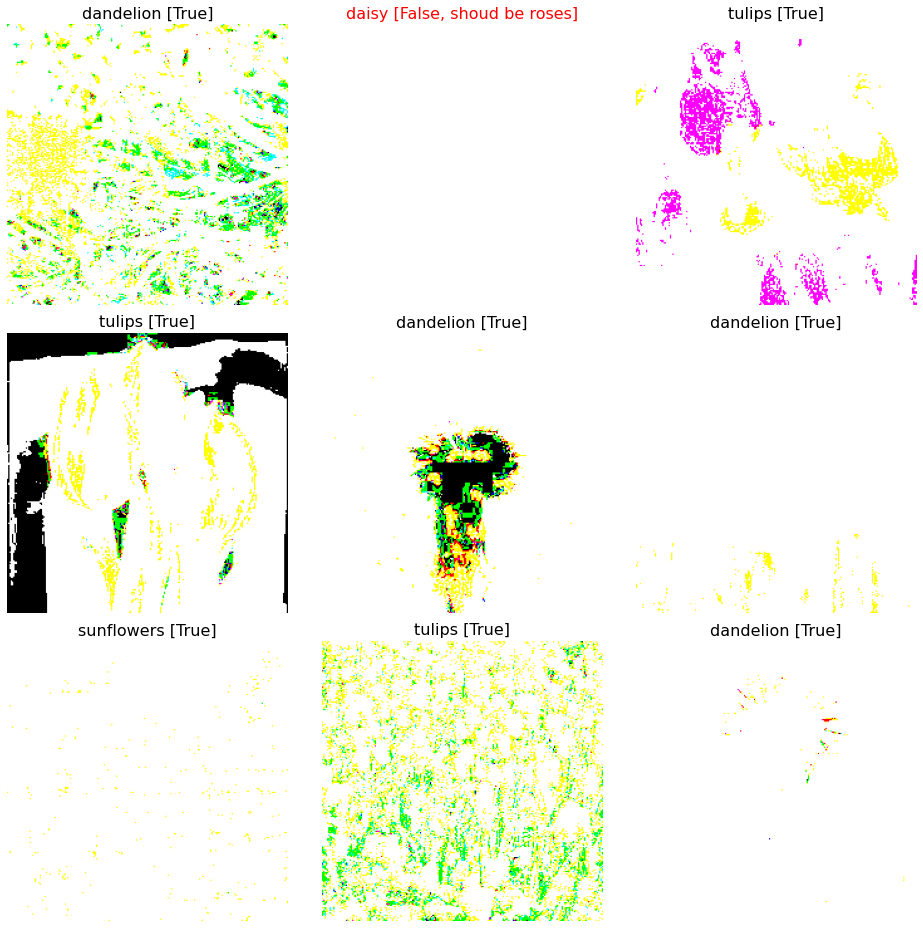

In [22]:
import numpy as np
# randomize the input so that you can execute multiple times to change results
permutation = np.random.permutation(8*20)
some_flowers, some_labels = (some_flowers[permutation], some_labels[permutation])

predictions = inference_model(some_flowers)

print(np.array(CLASSES)[np.argmax(predictions, axis=-1)].tolist())

display_9_images_with_predictions(some_flowers, predictions, some_labels)